In [1]:
import numpy as np
import os
import time

os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"

import keras
import keras.applications as kapp
from keras.datasets import cifar10
from keras.layers import Input, Conv2D, MaxPooling2D, Dense, Activation, Dropout, Flatten
from keras.optimizers import SGD

from keras.models import Sequential

import png as png
from keras import metrics

print metrics,dir(metrics)
from keras import backend as K

(x_train, y_train), (x_test, y_test) = cifar10.load_data()
batch_size = 40
testb_size = 40
x_testb = x_train[:testb_size]
#x_train = np.repeat(np.repeat(x_train, 7, axis=1), 7, axis=2)
num_classes=11

epochs = 48

Using plaidml.keras.backend backend.


<module 'keras.metrics' from '/Users/jonathanmiller/plaidml-venv/lib/python2.7/site-packages/keras/metrics.pyc'> ['K', 'MAE', 'MAPE', 'MSE', 'MSLE', '__builtins__', '__doc__', '__file__', '__name__', '__package__', 'absolute_import', 'binary_accuracy', 'binary_crossentropy', 'categorical_accuracy', 'categorical_crossentropy', 'cosine', 'cosine_proximity', 'deserialize', 'deserialize_keras_object', 'division', 'get', 'hinge', 'kullback_leibler_divergence', 'logcosh', 'mae', 'mape', 'mean_absolute_error', 'mean_absolute_percentage_error', 'mean_squared_error', 'mean_squared_logarithmic_error', 'mse', 'msle', 'poisson', 'print_function', 'serialize', 'serialize_keras_object', 'six', 'sparse_categorical_accuracy', 'sparse_categorical_crossentropy', 'sparse_top_k_categorical_accuracy', 'squared_hinge', 'top_k_categorical_accuracy']


I am using KERAS because it is one of the most friendly (in python) of high level interfaces. I am using plaidml because I develop on OS X and OS X machines do not generally have NVIDIA processors (this is one of the points where developing in OS X is a disadvantage). KERAS can do models in several different ways, I use one of the ways below.

I am using the png library for image visualization instead of matplotlib isn't being very friendly to OS X right now.

Here I set the batch size to 40. In our studies of DCNN for the vertex finding problem we found that generally you want the batch size to be 50 or above.

There are 10 classes in the cifar10 library (a small small image library that is a standard dataset in KERAS). We set the total epochs to 6.

In [2]:
for i in range(3):
    features_i = x_train[i,::]
    mag=7
    #print features_i,features_i.shape
    features_i = np.repeat(np.repeat(features_i, mag, axis=0), mag, axis=1)
    im = np.transpose(features_i,(1,2,0))
    height, width, depth = features_i.shape
    name = str(i)+'testinput.png'
    fpng = open(name, 'wb')
    w = png.Writer(width,height)
    pngWriter = png.Writer(width, height,
                           greyscale=False,
                           alpha=False,
                           bitdepth=16)
    w.write(fpng,np.reshape(features_i, (-1, width*3)))
    fpng.close()

This sell is to create png images for visualization. This is to visualize the images that we are going to be classifying. You can use the nice python features to be sure you have the shapes right which is one of the things to be more careful about in both python and DCNN work.

In [3]:
from IPython.display import Image


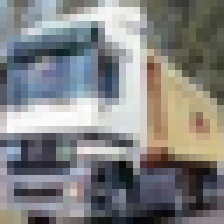

In [4]:
Image(filename='1testinput.png') 

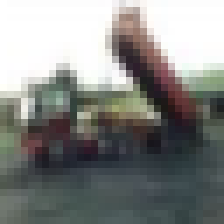

In [5]:
Image(filename='2testinput.png') 

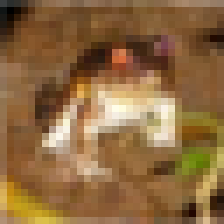

In [6]:
Image(filename='0testinput.png') 

These are example images. I have magnified them 7 times.

In [7]:
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)


model = Sequential()

firstlayer=Conv2D(8, (3, 3), activation='relu', input_shape=(32, 32, 3))
model.add(firstlayer)
model.add(Conv2D(8, (3, 3), activation='relu'))
model.add(Conv2D(16, (3, 3), activation='relu'))
model.add(Conv2D(16, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(3, 3)))

INFO:plaidml:Opening device "metal_intel(r)_iris(tm)_plus_graphics_640.0"


In [8]:
model.add(Dropout(0.25))



In [9]:
model.add(Flatten())
model.add(Dense(18, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(18, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

In [10]:
sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='mean_squared_error', optimizer=sgd,metrics=['categorical_accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 30, 30, 8)         224       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28L, 28L, 8)       584       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 26L, 26L, 16)      1168      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 24L, 24L, 16)      2320      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8L, 8L, 16L)       0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 8L, 8L, 16L)       0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1024)              0         
__________

Here we created the simply network. The shapes are important as are the number of parameters. You can see that while a lot of the work is done in the convolutional layers that most of the paramters are in the first dense layer. That is often the usual, here I have decreased the shape of the first dense layer to try and focus on the use of the convolutional layers.

A possibly outdated rule of thumb was that you should have 10 times more events or images than you have parameters.

Remember that dropout basically forces the NN to learn alternate representations of the image. We could probably make it more robust by adding additional dropout layers.

In [11]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_testb = x_testb.astype('float32')
x_train /= 255
x_test /= 255
x_testb /= 255


firstlayerw = firstlayer.get_weights()[0][:,:,0,:]

In [12]:
for i in range(2):
    name = str(i)+'testinputkernely.png'
    fpng = open(name, 'wb')
    mag=100
    w = png.Writer(3*mag,3*mag)
    im = np.repeat(np.repeat(firstlayerw[:,:,i]+0.5, mag, axis=0), mag, axis=1)
    im=im*255
    #print firstlayerw[:,:,i],firstlayerw[:,:,i].shape
    #print im,im.shape
    pngWriter = png.Writer(width, height,
                           greyscale=True,
                           alpha=False,
                           bitdepth=16)
    w.write(fpng,im)
    fpng.close()

In [13]:
Image(filename='0testinputkernely.png')

In [14]:
#help(png)

In [15]:
Image(filename='1testinputkernely.png')

I think these are randomly initiated. In fact, from our study of DCNN hyper-parameters using an evolutionary algorithm (MENNDL), the best performing DCNNs were those that got a bit lucky with a good set of initial weights. I suppose that this is something else that could be considered a parameter.

I still think it is stronger than doing feature engineering and a BDT/SVN.

In [16]:
history=model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(x_test, y_test),
          shuffle=True)

Train on 50000 samples, validate on 10000 samples
Epoch 1/48


INFO:plaidml:Analyzing Ops: 124 of 264 operations complete


50000/50000 [==============================] - 92s 2ms/step - loss: 0.0824 - categorical_accuracy: 0.1062 - val_loss: 0.0821 - val_categorical_accuracy: 0.1147
Epoch 2/48
50000/50000 [==============================] - 82s 2ms/step - loss: 0.0820 - categorical_accuracy: 0.1187 - val_loss: 0.0816 - val_categorical_accuracy: 0.1366
Epoch 3/48
50000/50000 [==============================] - 80s 2ms/step - loss: 0.0813 - categorical_accuracy: 0.1437 - val_loss: 0.0803 - val_categorical_accuracy: 0.2033
Epoch 4/48
50000/50000 [==============================] - 72s 1ms/step - loss: 0.0803 - categorical_accuracy: 0.1659 - val_loss: 0.0791 - val_categorical_accuracy: 0.2100
Epoch 5/48
50000/50000 [==============================] - 72s 1ms/step - loss: 0.0793 - categorical_accuracy: 0.1779 - val_loss: 0.0781 - val_categorical_accuracy: 0.2193
Epoch 6/48
50000/50000 [==============================] - 73s 1ms/step - loss: 0.0785 - categorical_accuracy: 0.1890 - val_loss: 0.0770 - val_categorical_ac

50000/50000 [==============================] - 83s 2ms/step - loss: 0.0635 - categorical_accuracy: 0.4170 - val_loss: 0.0568 - val_categorical_accuracy: 0.5301


Here we can do 12 epochs, and it is set to do a validation every epoch. Run in a different way you can have more control (we often do a validation run even every 0.10 epochs. An epoch is one pass through the dataset. Often another relevant number is dataset divided by batch size.

In [17]:
firstlayerw = firstlayer.get_weights()[0][:,:,0,:]
for i in range(2):
    name = str(i)+'testoutputkernely.png'
    fpng = open(name, 'wb')
    mag=100
    w = png.Writer(3*mag,3*mag)
    im = np.repeat(np.repeat(firstlayerw[:,:,i]+0.5, mag, axis=0), mag, axis=1)
    im=im*255
    #print firstlayerw[:,:,i],firstlayerw[:,:,i].shape
    #print im,im.shape
    pngWriter = png.Writer(width, height,
                           greyscale=True,
                           alpha=False,
                           bitdepth=16)
    w.write(fpng,im)
    fpng.close()

In [18]:
Image(filename='0testoutputkernely.png')

In [19]:
Image(filename='1testoutputkernely.png')

It doesn't look like the kernel has changed at all. I don't think that is one of the parameters that this network changes. These are 2 out of the 8 kernels in the first convolutional layer. You could imagine that if you have a smaller number of kernels, and the kernels don't change, that there might be a lot of luck involved.

I have tried to magnify these.

In [20]:
inp = model.input                                           # input placeholder
outputs = [layer.output for layer in model.layers]          # all layer outputs
functor = K.function([inp]+ [K.learning_phase()], outputs ) # evaluation function
import ROOT as rt

Welcome to JupyROOT 6.14/04


['val_categorical_accuracy', 'loss', 'categorical_accuracy', 'val_loss']
['AddressOf', 'MakeNullPointer', 'PyConfig', 'SetMemoryPolicy', 'SetOwnership', 'SetSignalPolicy', 'TCanvas', 'TROOT', 'Template', '_TTabComHook', '__doc__', '__file__', '__name__', 'cout', 'disableJSVis', 'disableJSVisDebug', 'enableJSVis', 'enableJSVisDebug', 'gInterpreter', 'gROOT', 'gSystem', 'kMemoryHeuristics', 'kMemoryStrict', 'kSignalFast', 'kSignalSafe', 'keeppolling', 'module', 'std']
<type 'numpy.ndarray'>
<type 'list'>


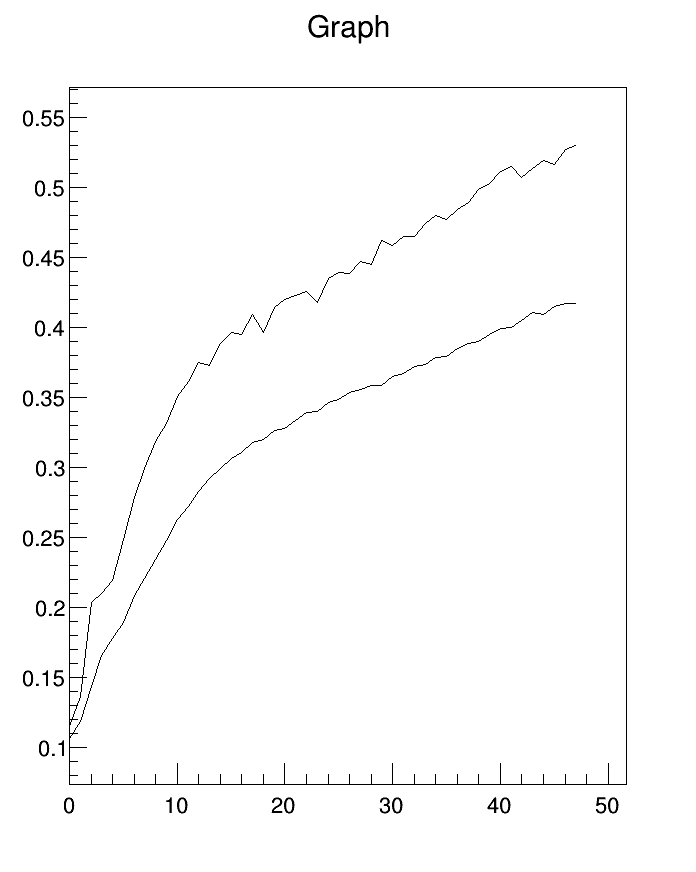

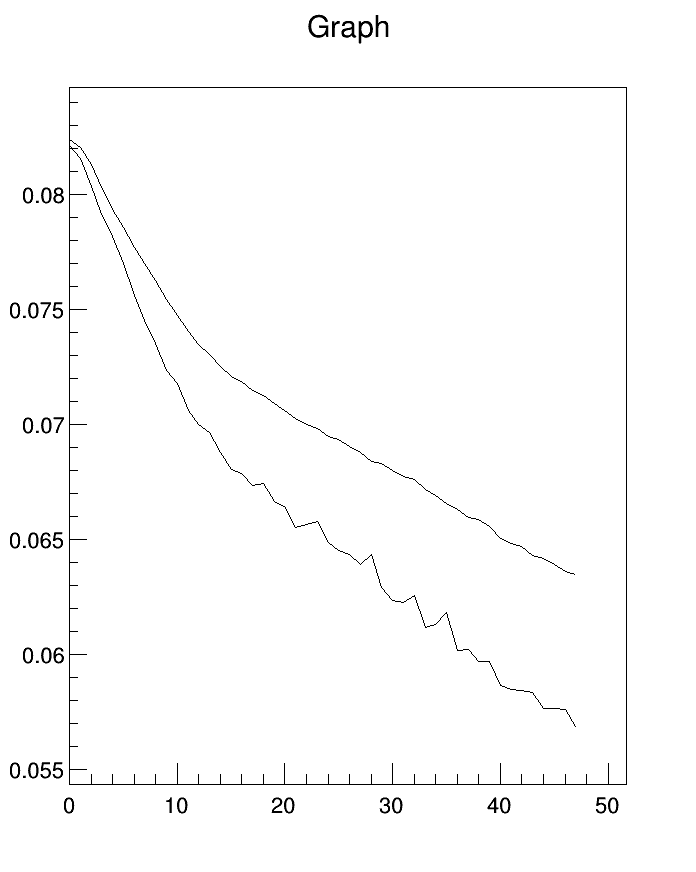

In [21]:
print(history.history.keys())
c1=rt.TCanvas( 'c1', 'c1', 200, 10, 700, 900 )
print dir(rt)
epocharray=np.arange(epochs) 
print type(epocharray)
print type(history.history['categorical_accuracy'])
gr1=rt.TGraph(epochs,epocharray.astype(float),np.asarray(history.history['categorical_accuracy'],float))
gr2=rt.TGraph(epochs,epocharray.astype(float),np.asarray(history.history['val_categorical_accuracy'],float))
gr3=rt.TGraph(epochs,epocharray.astype(float),np.asarray(history.history['loss'],float))
gr4=rt.TGraph(epochs,epocharray.astype(float),np.asarray(history.history['val_loss'],float))

gr2.Draw("")
gr1.Draw("same")
c1.Modified()
c1.Update()
c2=rt.TCanvas( 'c2', 'c2', 200, 10, 700, 900 )
gr4.Draw("")
gr3.Draw("same")
c2.Modified()
c2.Update()

rt.gROOT.GetListOfCanvases().Draw()

This is not ROOT nice yet (but may be in time for the lecture, or if you want to review it later). However, we can use ROOT or matplotlib to see how the loss and accuracy (standard metrics for DCNN) are changing as data continues to be acquired.

We note that the slope is still very strong. That means that even at 12 epochs the DCNN is still learning a lot. You really want to train to the point where the curve becomes flat.

We don't see it become flat, but we do see it possibly flattening.

In [22]:
for i in range(1):
    #print x_testb.shape
    features_i = x_testb[3,::]*255
    #print features_i,features_i.shape
    mag=7
    #print features_i
    features_i = np.repeat(np.repeat(features_i, mag, axis=0), mag, axis=1)
    im = np.transpose(features_i,(1,2,0))
    height, width, depth = features_i.shape
    name = str(i)+'testinputpic.png'
    fpng = open(name, 'wb')
    w = png.Writer(width,height)
    pngWriter = png.Writer(width, height,
                           greyscale=False,
                           alpha=False,
                           bitdepth=16)
    w.write(fpng,np.reshape(features_i, (-1, width*3)))
    fpng.close()

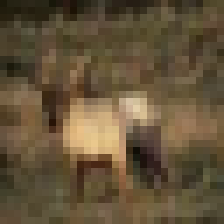

In [23]:
Image(filename='0testinputpic.png')

Here is the image we will investigate in greater detail. It is magnified 7 times.

In [24]:
layer_outs = functor([x_testb, 1.])
for i in range(7):
    #print x_testb.shape
    features_i = layer_outs[0][3]*125
    #print features_i.shape
    mag=7
    #print features_i
    features_i = np.repeat(np.repeat(features_i, mag, axis=0), mag, axis=1)
    im = np.transpose(features_i,(2,1,0))
    print im.shape,im[i].shape
    #im = np.transpose(im[0],(2,1,0))
    height, width =im[i].shape
    name = str(i)+'testoutputpic.png'
    fpng = open(name, 'wb')
    print width,height
    w = png.Writer(width,height)
    pngWriter = png.Writer(width, height,
                           greyscale=True,
                           alpha=False,
                           bitdepth=16)
    w.write(fpng,np.reshape(im[i], (-1, width*1)))
    fpng.close()


(8, 210, 210) (210, 210)
210 210
(8, 210, 210) (210, 210)
210 210
(8, 210, 210) (210, 210)
210 210
(8, 210, 210) (210, 210)
210 210
(8, 210, 210) (210, 210)
210 210
(8, 210, 210) (210, 210)
210 210
(8, 210, 210) (210, 210)
210 210


In [25]:
Image(filename='0testoutputpic.png')

In [26]:
Image(filename='1testoutputpic.png')

In [27]:
Image(filename='2testoutputpic.png')

In [28]:
Image(filename='3testoutputpic.png')

In [29]:
Image(filename='4testoutputpic.png')

In [30]:
Image(filename='5testoutputpic.png')

In [31]:
Image(filename='6testoutputpic.png')

Here are 7 images produced by applying the 7 kernels to the image. 

In [32]:
#Image(filename='7testoutputpic.png')

In [33]:
for i in range(7):
    #print x_testb.shape
    features_i = layer_outs[1][3]*125
    #print features_i.shape
    mag=7
    #print features_i
    features_i = np.repeat(np.repeat(features_i, mag, axis=0), mag, axis=1)
    im = np.transpose(features_i,(2,1,0))
    #print im.shape,im[i].shape
    #im = np.transpose(im[0],(2,1,0))
    height, width =im[i].shape
    name = str(i)+'testoutputpic2.png'
    fpng = open(name, 'wb')
    print width,height
    w = png.Writer(width,height)
    pngWriter = png.Writer(width, height,
                           greyscale=True,
                           alpha=False,
                           bitdepth=16)
    w.write(fpng,np.reshape(im[i], (-1, width*1)))
    fpng.close()

196 196
196 196
196 196
196 196
196 196
196 196
196 196


In [34]:
Image(filename='0testoutputpic2.png')

In [35]:
Image(filename='1testoutputpic2.png')

In [36]:
Image(filename='2testoutputpic2.png')

In [37]:
Image(filename='3testoutputpic2.png')

In [38]:
Image(filename='4testoutputpic2.png')

In [39]:
Image(filename='5testoutputpic2.png')

In [40]:
Image(filename='6testoutputpic2.png')

In [41]:
#Image(filename='7testoutputpic2.png')

Here is after application of he second kernel.